In [54]:
import subprocess
import sqlite3

con = sqlite3.connect("pt.db")
cur = con.cursor()

# set the time bounds
# calculate ipc over buckets
cur.execute('DROP TABLE IF EXISTS time_bounds;')
        #"range_start_ns": 4472714308357,
        #"range_end_ns": 4472714316324,
#start_ns, end_ns = 4472714309000, 4472714312000
start_ns, end_ns = 4472714308357, 4472714316324
cur.execute('CREATE TABLE time_bounds as values ({}), ({});'.format(start_ns, end_ns))
data = cur.fetchall()

# define the ipc buckets
with open("ipc_over_time_ddl.sql") as script:
    text = script.read()
    sql_script = text.format(**{
        "bucket_length_cyc" : 250,
        "bucket_tick_cyc": 250,
    })
# python itself must be configured at build time to enable sqlite3 loadable
# extensions.  It is not by default.
# wtf.
subprocess.run(
    ['sqlite3', 'pt.db'],
    timeout=30,
    input=sql_script,
    text=True,
    ).check_returncode()

# locate syscalls
with open("callstacks.sql") as script:
    sql_script = script.read()

# python itself must be configured at build time to enable sqlite3 loadable
# extensions.  It is not by default.
# wtf.
subprocess.run(
    ['sqlite3', 'pt.db'],
    timeout=30,
    input=sql_script,
    text=True,
    ).check_returncode()

Text(0.5, 1.0, 'syscall events')

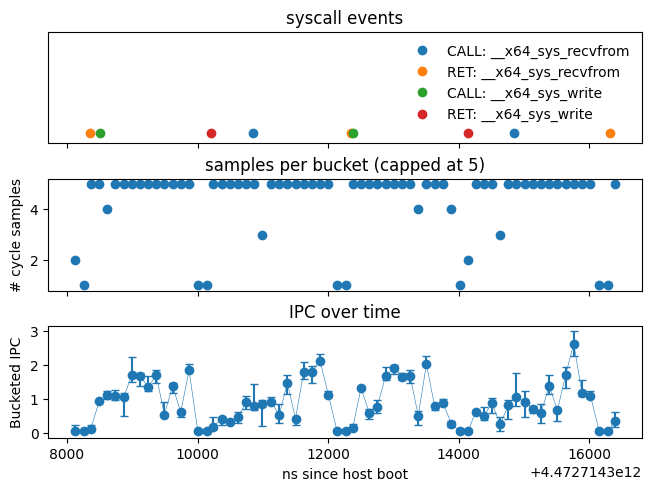

In [80]:
from matplotlib import pyplot as plt
import collections
import numpy
import math
import sqlite3
%matplotlib inline

con = sqlite3.connect("pt.db")
cur = con.cursor()

# calculate ipc over buckets
cur.execute('select * from ipc_over_time order by bucket_start_cyc;')
data = cur.fetchall()

(
    _,
    bucket_end_time,
    _,
    _,
    bucket_spans_ranges,
    linear_interp_ipc,
    conservative_ipc,
    optimistic_ipc
 ) = zip(*data)

lower_error = [t[0] - t[1] for t in zip(linear_interp_ipc, conservative_ipc)]
upper_error = [t[0] - t[1] for t in zip(optimistic_ipc, linear_interp_ipc)]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, layout='constrained')
ax3.errorbar(
    bucket_end_time,
    linear_interp_ipc,
    yerr=[lower_error, upper_error],
    fmt='o-',
    elinewidth=1.5,
    linewidth=0.4,
    capsize=3.0,
    capthick=1.0)
ax3.set_xlabel("ns since host boot")
ax3.set_ylabel("Bucketed IPC")
ax3.set_title("IPC over time")

# cap spans at 5.  Knowing it is at least 5 is good enough
bucket_spans_ranges = [v if v < 5 else 5 for v in bucket_spans_ranges]
ax2.plot(bucket_end_time, bucket_spans_ranges, 'o')
ax2.set_ylabel("# cycle samples")
ax2.set_title("samples per bucket (capped at 5)")

cur.execute('''select event || ': ' || syscall_kernel_name, time from syscall_call_ret order by syscall_kernel_name, event;''')
data = cur.fetchall()
d = collections.defaultdict(list)
for t in data:
    d[t[0]].append(t[1])
for k,v in d.items():
    ax1.plot(v, [0] * len(v), 'o', label=k)
ax1.legend(
    loc="upper right",
    frameon=False,
    )
# force the markers to appear at the bottom
ax1.set_ylim(bottom=-0.1, top=1.0)
ax1.set_yticks([])
ax1.set_title('syscall events')
